In [1]:
#import necessary libraries
from torchtext.data import Field
from torchtext.data import TabularDataset
import pandas as pd
import re
import torch
import collections
import numpy as np
from torchtext.data import Iterator, BucketIterator
import json
import time
import tqdm

#output all items, not just last one
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

#set device
if torch.cuda.is_available():
    device= "cuda"
else:
    device = "cpu"  

In [2]:
class Articles(torch.utils.data.Dataset):
    def __init__(self, json_file):
        super().__init__()
        with open(json_file, "r") as data_file:
            self.examples = json.loads(data_file.read())
        self.tokenize()
    
    def __getitem__(self, idx):
        return self.examples[idx]
    
    def __len__(self):
        return len(self.examples)
    
    def tokenize(self):
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = re.findall('[\w]+', self.examples[idx]['text'].lower())
            self.examples[idx]['title'] = re.findall('[\w]+', self.examples[idx]['title'].lower())
    
    def create_weighted_sampler(self):
        prob = np.zeros(len(self))
        positive = sum(example['longform'] == 0 for example in self.examples)
        negative = len(self) - positive
        for idx, example in enumerate(self.examples):
            if example['longform'] == 0:
                prob[idx] = (positive/(len(self)))
            else:
                prob[idx] = (negative/(len(self)))
        return torch.utils.data.WeightedRandomSampler(weights=prob, num_samples=len(self), replacement=True)
    
    def create_dictionaries(self):
        counter = collections.Counter()
        url_counter = collections.Counter()
        urls = []

        for example in self.examples:
            counter.update(example['text'])
            counter.update(example['title'])
            urls.append(example['url'])

        url_counter.update(urls)
        word_to_id = {word: id for id, word in enumerate(counter.keys())}
        article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
        return word_to_id, article_to_id
    
    def map_items(self, word_to_id, url_to_id):
        words = []
        articles = []
        labels = []
        for idx, example in enumerate(self.examples):
            self.examples[idx]['text'] = [word_to_id.get(word, len(word_to_id)) for word in example['text']]
            self.examples[idx]['title'] = [word_to_id.get(word, len(word_to_id)) for word in example['title']]
            self.examples[idx]['url'] = url_to_id.get(example['url'])
            
    def clone(self):
        return self

In [4]:
def create_merged_dictionaries(train, test, val, eval_):
    counter = collections.Counter()
    url_counter = collections.Counter()
    urls = []

    for example in train.examples + test.examples + val.examples + eval_.examples:
        counter.update(example['text'])
        counter.update(example['title'])
        urls.append(example['url'])

    url_counter.update(urls)
    word_to_id = {word: id for id, word in enumerate(counter.keys())}
    article_to_id = {word: id for id, word in enumerate(url_counter.keys())}
    return word_to_id, article_to_id

train_data = Articles("changed-data/train.json")
test_data = Articles("changed-data/test.json")
val_data = Articles("changed-data/validate.json")
eval_data = Articles("eval-data/eval-data.json")
print("Data Loaded")
# train_data = Articles("changed-data/debugdata/train_basic.json")
# test_data = Articles("changed-data/debugdata/test_basic.json")
# val_data = Articles("changed-data/debugdata/val_basic.json")

Data Loaded


In [5]:
final_word_ids,final_url_ids= create_merged_dictionaries(train_data, test_data, val_data, eval_data)
print("Dictionaries Created")

for dataset in [train_data, test_data, val_data, eval_data]:
    dataset.map_items(final_word_ids, final_url_ids);
    
print("Items mapped")

Dictionaries Created
Items mapped


In [6]:
with open("dictionaries/word_dictionary.json", "w") as file:
    json.dump(final_word_ids, file)

with open("dictionaries/article_dictionary.json", "w") as file:
    json.dump(final_url_ids, file)

In [7]:
list(final_url_ids.items())[-10:]

[('https://www.wired.com/story/clearview-ai-client-list-cerberus-malware-security-news/',
  123080),
 ('https://www.wired.com/story/plant-shutdowns-vital-truckers-more-car-news/',
  123081),
 ('https://www.wired.com/story/traffic-spreads-like-disease/', 123082),
 ('https://www.wired.com/story/tesla-cruising-investors-going-joyride/',
  123083),
 ('https://www.wired.com/story/opinion-to-end-the-pandemic-give-universal-testing-the-green-light/',
  123084),
 ('https://www.wired.com/story/code-obsessed-novelist-builds-writing-bot-the-plot-thickens/',
  123085),
 ('https://www.wired.com/story/travel-bans-and-quarantines-wont-stop-coronavirus/',
  123086),
 ('https://www.wired.com/story/sundar-pichai-on-google-maps-at-15/', 123087),
 ('https://www.wired.com/story/google-maps-jen-fitzpatrick-q-and-a/', 123088),
 ('https://www.wired.com/story/cisco-hack-vulnerability-locusts-africa/',
  123089)]

In [43]:
def collate_fn(examples):
    words = []
    articles = []
    labels = []
    for example in examples:
        words.append(list(set(example['text'])))
        articles.append(example['url'])
        labels.append(example['longform'])
    num_words = [len(x) for x in words]
    words = np.concatenate(words, axis=0)
    word_attributes = torch.tensor(words, dtype=torch.long)
    articles = torch.tensor(articles, dtype=torch.long)
    num_words.insert(0,0)
    num_words.pop(-1)
    attribute_offsets = torch.tensor(np.cumsum(num_words), dtype=torch.long)
    publications = torch.tensor([0])
    labels = torch.tensor(labels, dtype=torch.float)
    return publications, articles, word_attributes, attribute_offsets, labels

In [44]:
import torch.nn as nn

class InnerProduct(nn.Module):
    def __init__(self, n_publications, n_articles, n_attributes, emb_size, sparse, use_article_emb):
        super().__init__()
        self.emb_size = emb_size
        self.publication_embeddings = nn.Embedding(n_publications, emb_size, sparse=sparse)
        self.publication_bias = nn.Embedding(n_publications, 1, sparse=sparse)
        self.attribute_emb_sum = nn.EmbeddingBag(n_attributes, emb_size, mode='sum', sparse=sparse)
        self.attribute_bias_sum = nn.EmbeddingBag(n_attributes, 1, mode='sum', sparse=sparse)
        self.use_article_emb = use_article_emb
        if use_article_emb:
            self.article_embeddings = nn.Embedding(n_articles, emb_size, sparse=sparse)
            self.article_bias = nn.Embedding(n_articles, 1, sparse=sparse)
        self.use_article_emb = use_article_emb

    def reset_parameters(self):
        for module in [self.publication_embeddings, self.attribute_emb_sum]:
            scale = 0.07
            nn.init.uniform_(module.weight, -scale, scale)
        for module in [self.publication_bias, self.attribute_bias_sum]:
            nn.init.zeros_(module.weight)
        if self.use_article_emb:
            for module in [self.article_embeddings, self.article_bias]:
            # initializing article embeddings to zero to allow large batch sizes
            # nn.init.uniform_(module.weight, -scale, scale)
                nn.init.zeros_(module.weight)

    def forward(self, publications, articles, word_attributes, attribute_offsets, pairwise=False, return_intermediate=False):
        publication_emb = self.publication_embeddings(publications)
        attribute_emb = self.attribute_emb_sum(word_attributes, attribute_offsets)
        if self.use_article_emb:
            article_and_attr_emb = self.article_embeddings(articles) + attribute_emb
        else:
            article_and_attr_emb = attribute_emb
        attr_bias = self.attribute_bias_sum(word_attributes, attribute_offsets)
        publication_bias = self.publication_bias(publications)
        if pairwise:
          # for every publication, compute inner product with every article
          # (publications, emb_size) x (emb_size, articles) -> (publications, articles)
            inner_prod = publication_emb @ article_and_attr_emb.t()
          # broadcasting across publication dimension
            logits = inner_prod + publication_bias
          # broadcast across article dimension
            logits += attr_bias.t()
            if self.use_article_emb:
                logits += self.article_bias(articles).t()
        else:
              # for every publication, only compute inner product with corresponding minibatch element
              # (batch_size, 1, emb_size) x (batch_size, emb_size, 1) -> (batch_size, 1)
              # logits = torch.bmm(publication_emb.view(-1, 1, self.emb_size), 
              #                    (article_and_attr_emb).view(-1, self.emb_size, 1)).squeeze()
            inner_prod = (publication_emb * article_and_attr_emb).sum(-1)
            logits = inner_prod + attr_bias.squeeze() + publication_bias.squeeze()
            if self.use_article_emb:
                logits += self.article_bias(articles).squeeze()
        if return_intermediate:
            return logits, publication_emb, attribute_emb
        else:
            return logits
        

In [45]:
train_weight_sampler = train_data.create_weighted_sampler()
train_batch_sampler = torch.utils.data.BatchSampler(train_weight_sampler, 64, drop_last=True)

train_loader = torch.utils.data.DataLoader(train_data, batch_sampler=train_batch_sampler, collate_fn=collate_fn, pin_memory=True)

In [46]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=len(val_data), collate_fn=collate_fn, pin_memory=True)

In [47]:
from tqdm.notebook import tqdm

kwargs = dict(n_publications=1, 
              n_articles=len(final_url_ids), 
              n_attributes=len(final_word_ids), 
              emb_size=100, sparse=False, 
              use_article_emb=False)
model = InnerProduct(**kwargs)
model.reset_parameters()
model.to(device)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4,momentum=0.9)

val_batch = next(iter(val_loader))
val_publications, val_articles, val_word_attributes, val_attribute_offsets, val_labels = val_batch
val_publications = val_publications.to(device)
val_articles = val_articles.to(device)
val_word_attributes = val_word_attributes.to(device)
val_attribute_offsets = val_attribute_offsets.to(device)
val_labels = val_labels.to(device)
print(len(val_labels))
model.train() # turn on training mode
check=True

while check: 
    for step,batch in enumerate(tqdm(cycle(train_loader))):
        optimizer.zero_grad();
        publications, articles, word_attributes, attribute_offsets, labels = batch
        publications = publications.to(device)
        articles = articles.to(device)
        word_attributes = word_attributes.to(device)
        attribute_offsets = attribute_offsets.to(device)
        labels = labels.to(device)
        logits = model(publications, articles, word_attributes, attribute_offsets)
        L = loss(logits, labels)
        L.backward();
        optimizer.step();
        if step % 50 == 0 and step % 400 != 0:
            model.eval();
            preds = model(val_publications, val_articles, val_word_attributes, val_attribute_offsets)
            sorted_preds, indices = torch.sort(preds, descending=True)
            correct_10=0
            correct_100=0
            for i in range(0,10):
                if val_labels[indices[i]] == 1:
                    correct_10 += 1
            for i in range(0, 100):
                if val_labels[indices[i]] == 1:
                    correct_100 += 1
            print("Top 10: ", correct_10, "/10 or ", (correct_10*10), "%")
            print("Top 100: ", correct_100, "/100 or", correct_100, "%")
            model.train();
        if step != 0 and step % 400 == 0:
            model.eval();
            preds = model(val_publications, val_articles, val_word_attributes, val_attribute_offsets)
            sorted_preds, indices = torch.sort(preds, descending=True)
            df = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
            links = list(final_url_ids.keys())
            for i in range(0, 1000):
                example = val_data[indices[i]]
                prediction = sorted_preds[i].item()
                text = []
                for x in example['title']:
                    text.append(next((word for word, numero in final_word_ids.items() if numero == x), None))
                    title = ""
                for word in text:
                    title += word
                    title += " "
                short_text = list(set(example['text']))
                url = links[example['url']]
                longform = example['longform']
                df.loc[i] = [title, url, short_text, longform, prediction]
            df.head()
            df.to_csv("top-1000.csv")
            check=False
            break

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

11390


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  9 /10 or  90 %
Top 100:  57 /100 or 57 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  96 /100 or 96 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

Top 10:  10 /10 or  100 %
Top 100:  100 /100 or 100 %


InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

,title,url,text,longform,prediction
0,a long walk s end,http://www.sbnation.com/longform/2015/7/1/8861...,"[0, 3, 4, 7, 9, 11, 12, 14, 15, 22, 23, 25, 26...",1,27.433342
1,the transformation of johnny spain,http://www.chipbrown.net/articles/spain.htm,"[0, 3, 4, 7, 9, 11, 12, 8206, 15, 114706, 22, ...",1,22.719969
2,we a baddd people,http://www.vqronline.org/memoir-articles/2014/...,"[0, 1, 2, 3, 4, 7, 9, 12, 13, 15, 40981, 22, 2...",1,22.153280
3,the electric pencil,http://www.riverfronttimes.com/2012-09-14/news...,"[0, 1, 3, 4, 7, 9, 12, 13, 15, 23, 25, 26, 27,...",1,22.140244
4,the killer cadets,http://www.texasmonthly.com/articles/the-kille...,"[0, 1, 3, 4, 7, 9, 12, 13, 14, 15, 23, 25, 26,...",1,21.567389


In [93]:
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=len(eval_data), collate_fn=collate_fn, pin_memory=True)

eval_batch = next(iter(eval_loader))
eval_publications, eval_articles, eval_word_attributes, eval_attribute_offsets, eval_labels = eval_batch
eval_publications = eval_publications.to(device)
eval_articles = eval_articles.to(device)
eval_word_attributes = eval_word_attributes.to(device)
eval_attribute_offsets = eval_attribute_offsets.to(device)
eval_labels = eval_labels.to(device)

model.eval()
eval_preds = model(eval_publications, eval_articles, eval_word_attributes, eval_attribute_offsets)
eval_sorted_preds, locations = torch.sort(eval_preds, descending=True)
eval_sort = pd.DataFrame(columns=['title', 'url', 'text','longform', 'prediction'])
for i in range(0, 1000):
    example = eval_data[locations[i]]
    prediction = eval_sorted_preds[i].item()
    text = []
    for x in example['title']:
        text.append(next((word for word, numero in final_word_ids.items() if numero == x), "unk"))
        title = ""
    for word in text:
        title += word
        title += " "
    short_text = list(set(example['text']))
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    longform = example['longform']
    eval_sort.loc[i] = [title, url, short_text, longform, prediction]
eval_sort.head()

InnerProduct(
  (publication_embeddings): Embedding(1, 100)
  (publication_bias): Embedding(1, 1)
  (attribute_emb_sum): EmbeddingBag(380917, 100, mode=sum)
  (attribute_bias_sum): EmbeddingBag(380917, 1, mode=sum)
)

,title,url,text,longform,prediction
0,the strange and mysterious death of mrs jerry ...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...",0,24.655338
1,bellagio bandit how one man robbed vegas bigge...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 9, 12, 13, 14, 17, 16403, 23, ...",0,21.356615
2,cult killing kids in the dark,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 24577, 3, 4, 7, 9, 11, 12, 13, 14, 15, ...",0,18.623064
3,the lost years and last days of david foster w...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 8198, 7, 9, 11, 12, 13, 15, 16404...",0,18.595238
4,j paul getty iii exclusive 1974 interview with...,https://www.rollingstone.com/culture/culture-f...,"[0, 1, 3, 4, 7, 9, 11, 12, 13, 15, 22, 23, 25,...",0,18.159470


In [49]:
total_eval = pd.concat([df, eval_sort], ignore_index=True)
sorted_total_eval = total_eval.sort_values(by='prediction', ascending=False)

In [50]:
sorted_total_eval.to_csv("ranked-eval.csv", index=False)

In [51]:
sorted_total_eval.text.head()

0       [0, 3, 4, 7, 9, 11, 12, 14, 15, 22, 23, 25, 26...
1000    [0, 1, 3, 4, 7, 8199, 9, 11, 12, 13, 15, 8208,...
1       [0, 3, 4, 7, 9, 11, 12, 8206, 15, 114706, 22, ...
2       [0, 1, 2, 3, 4, 7, 9, 12, 13, 15, 40981, 22, 2...
3       [0, 1, 3, 4, 7, 9, 12, 13, 15, 23, 25, 26, 27,...
Name: text, dtype: object

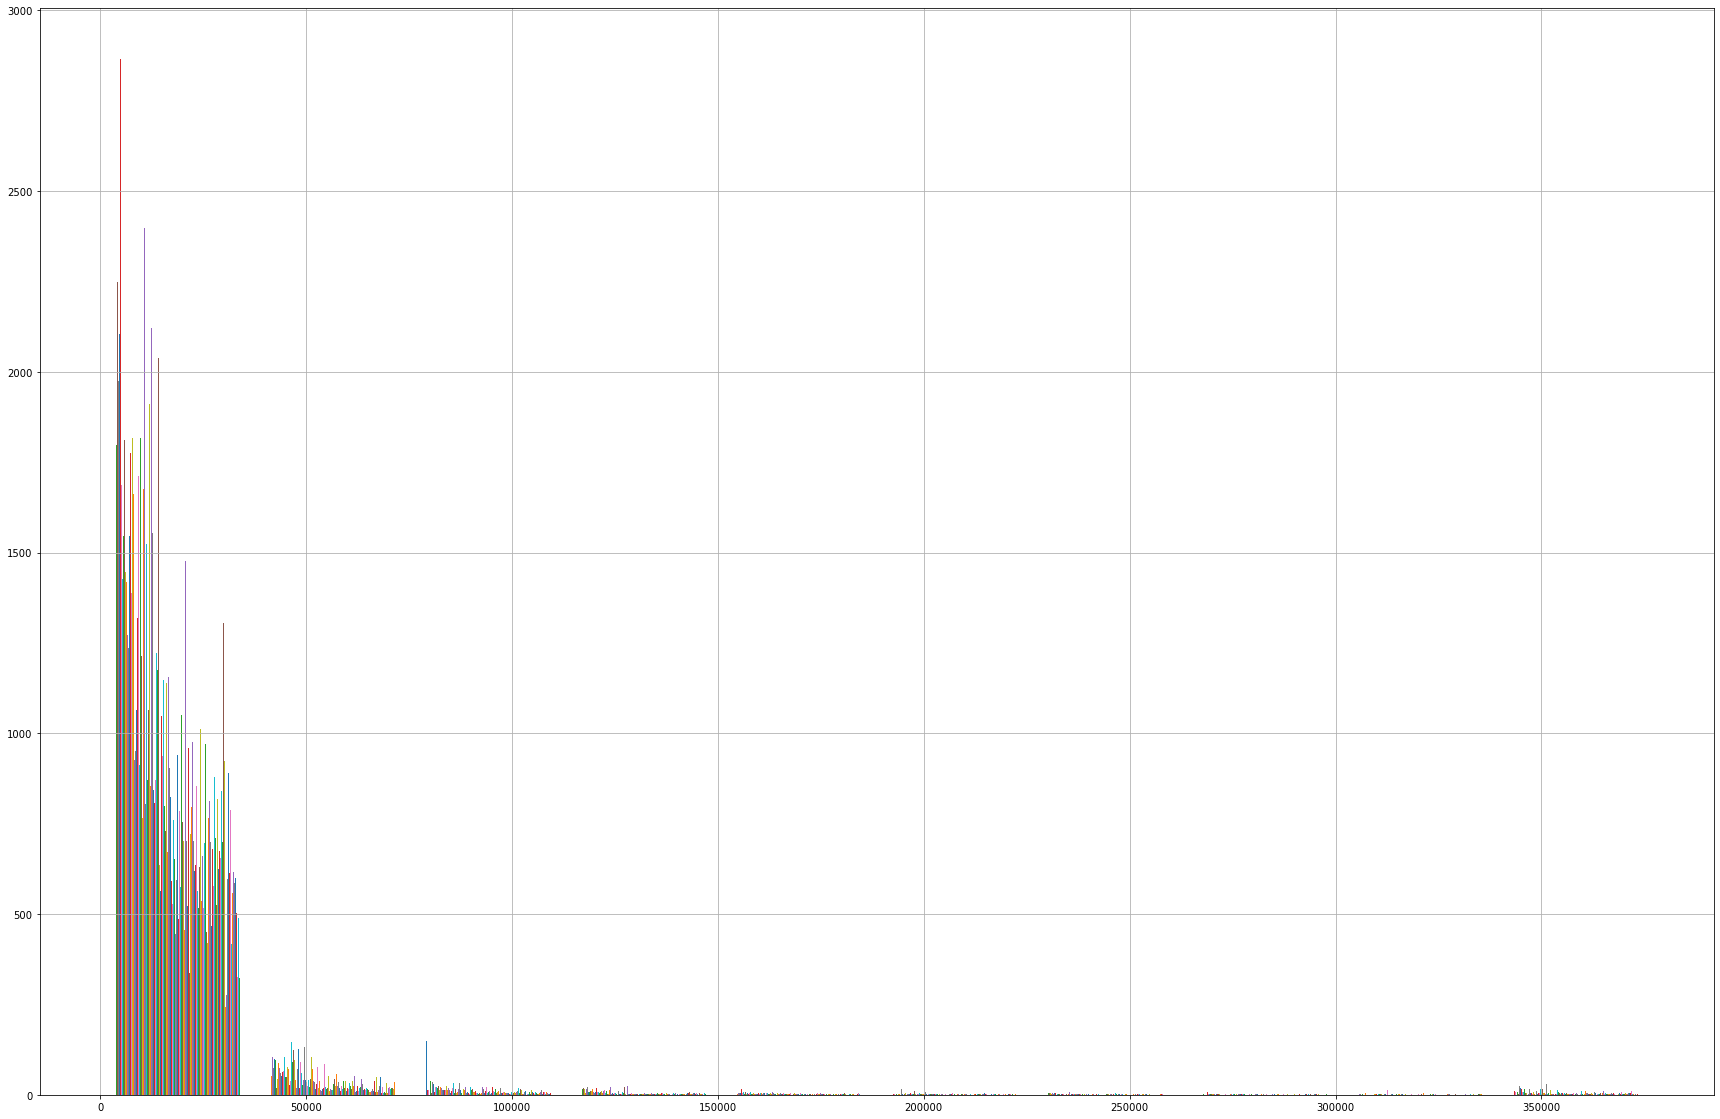

In [52]:
sorted_total_eval[sorted_total_eval.url.str.contains("rollingstone")].text.hist(figsize=(30,20))

In [86]:
counter = collections.Counter()
for i in range(0, 2000):
    sorted_total_eval['text'][i] = list(sorted_total_eval['text'][i])
    counter.update(sorted_total_eval['text'][i])

rolling_df = sorted_total_eval[sorted_total_eval.url.str.contains("rollingstone")].reset_index(drop=True)
rollingcounter = collections.Counter()
for i in range(0, len(rolling_df)):
    rolling_df['text'][i] = list(rolling_df['text'][i])
    rollingcounter.update(rolling_df['text'][i])

c:\users\rohan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\rohan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<Figure size 2160x1440 with 0 Axes>

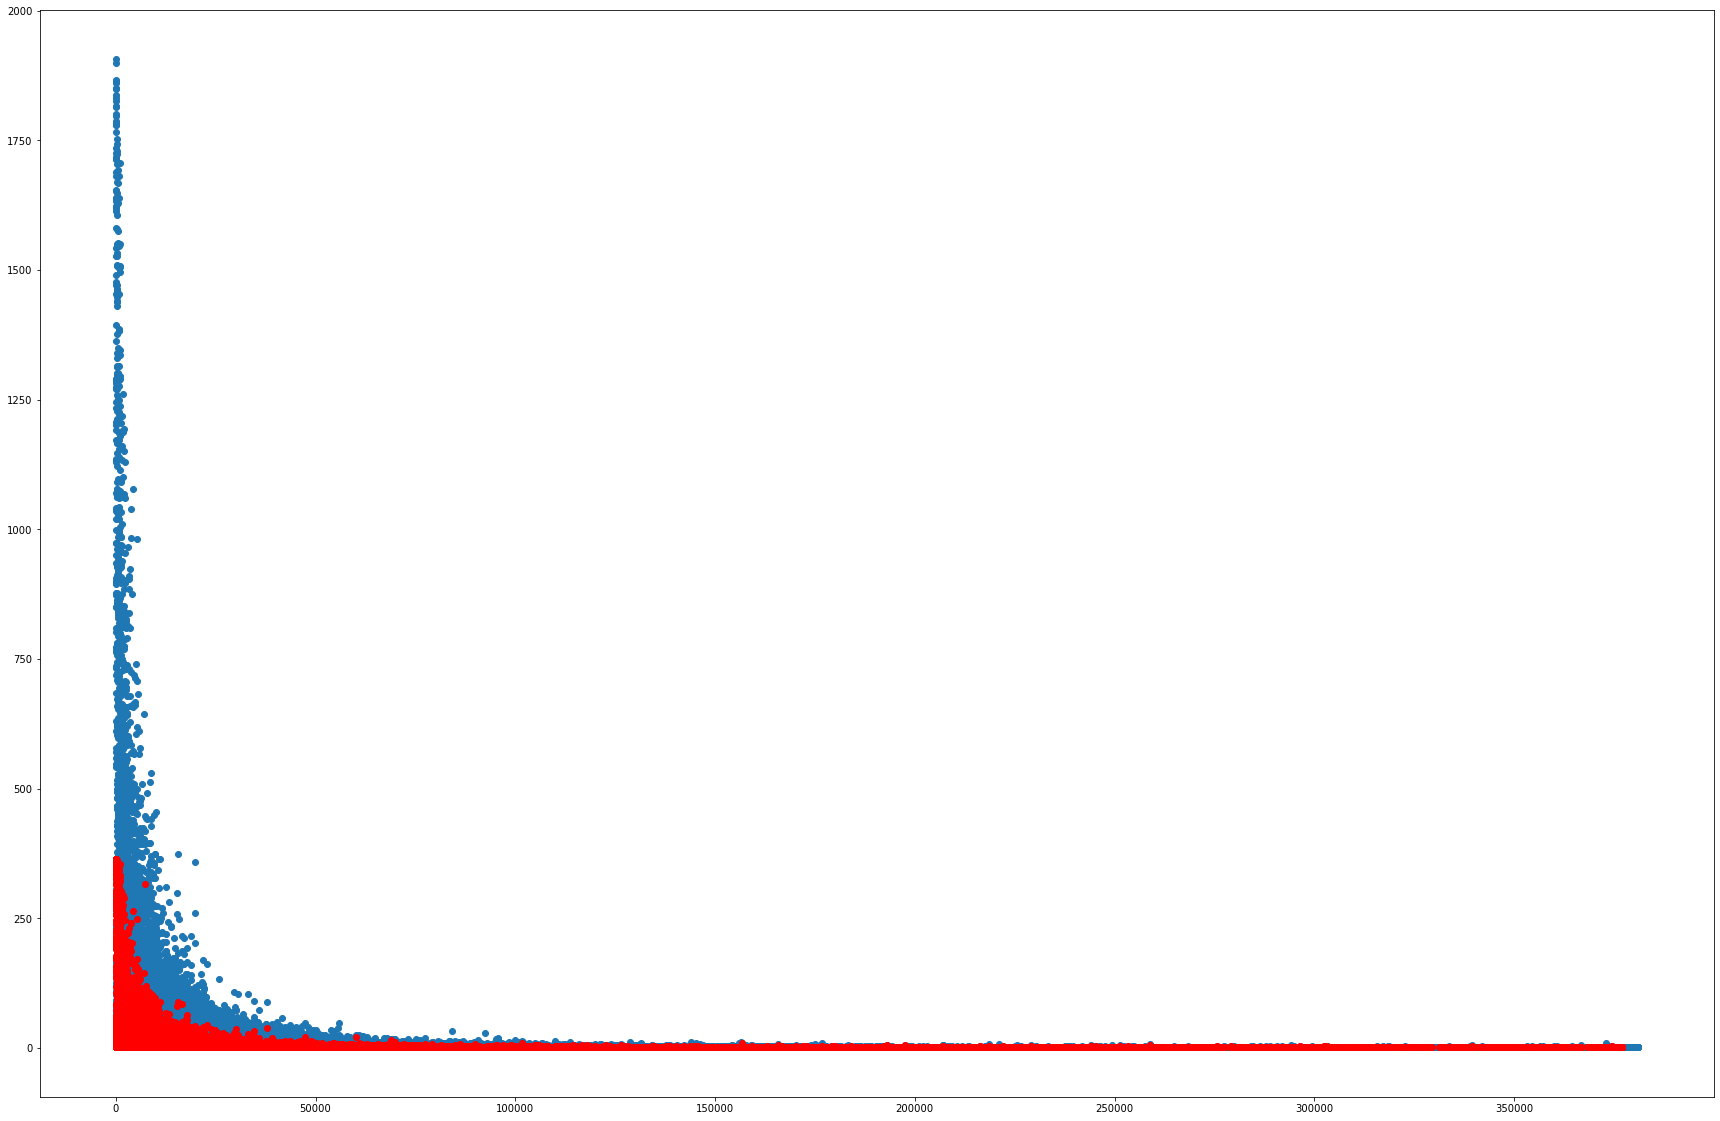

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.scatter(*zip(*counter.most_common()))
plt.scatter(*zip(*rollingcounter.most_common()), color="red")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
plt.scatter(*zip(*rollingcounter.most_common()))
plt.show()

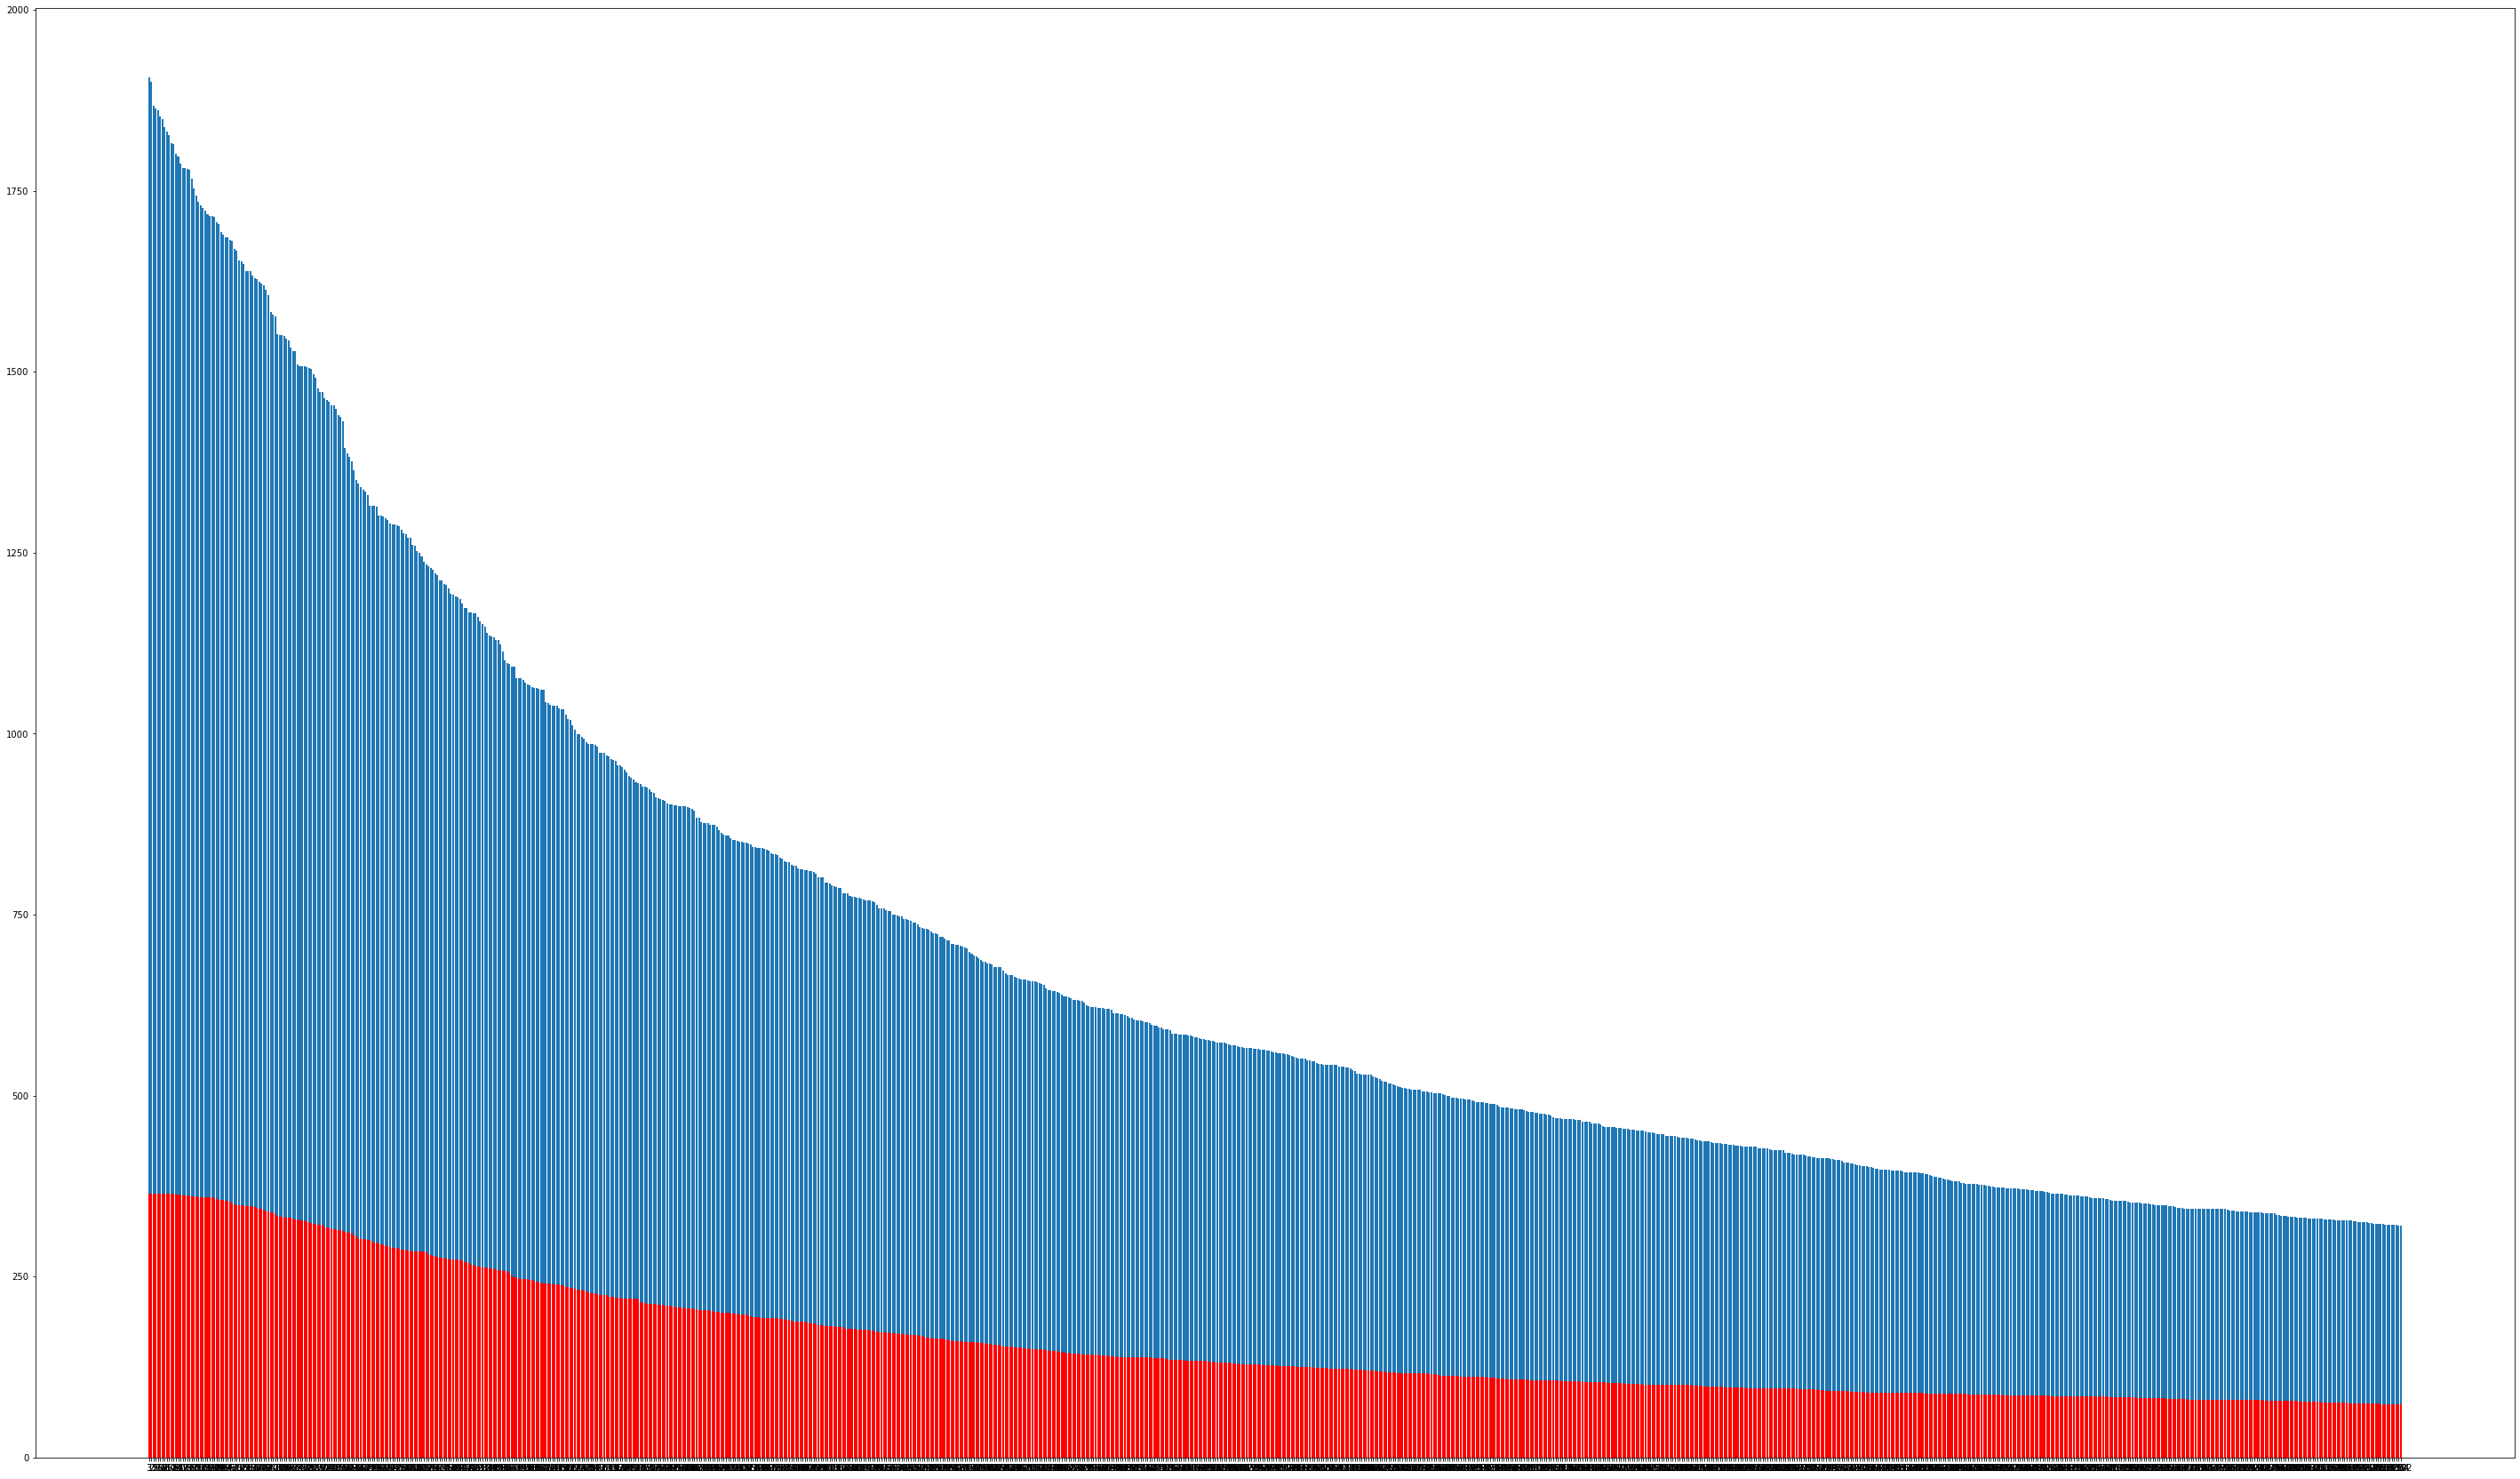

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,30))
word_places = list(zip(*counter.most_common()))[0][:1000]
freqs = list(zip(*counter.most_common()))[1][:1000]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs);
plt.xticks(x_pos, word_places);
word_places = list(zip(*rollingcounter.most_common()))[0][:1000]
freqs = list(zip(*rollingcounter.most_common()))[1][:1000]
x_pos = np.arange(len(word_places))
plt.bar(x_pos, freqs, color="red");
plt.xticks(x_pos, word_places);
plt.show();

In [66]:
publication_emb = model.publication_embeddings.weight.data[0].cpu().numpy()
word_emb = model.attribute_emb_sum.weight.data.cpu().numpy()
word_emb.shape
inner_products = (publication_emb * word_emb).sum(axis=1)

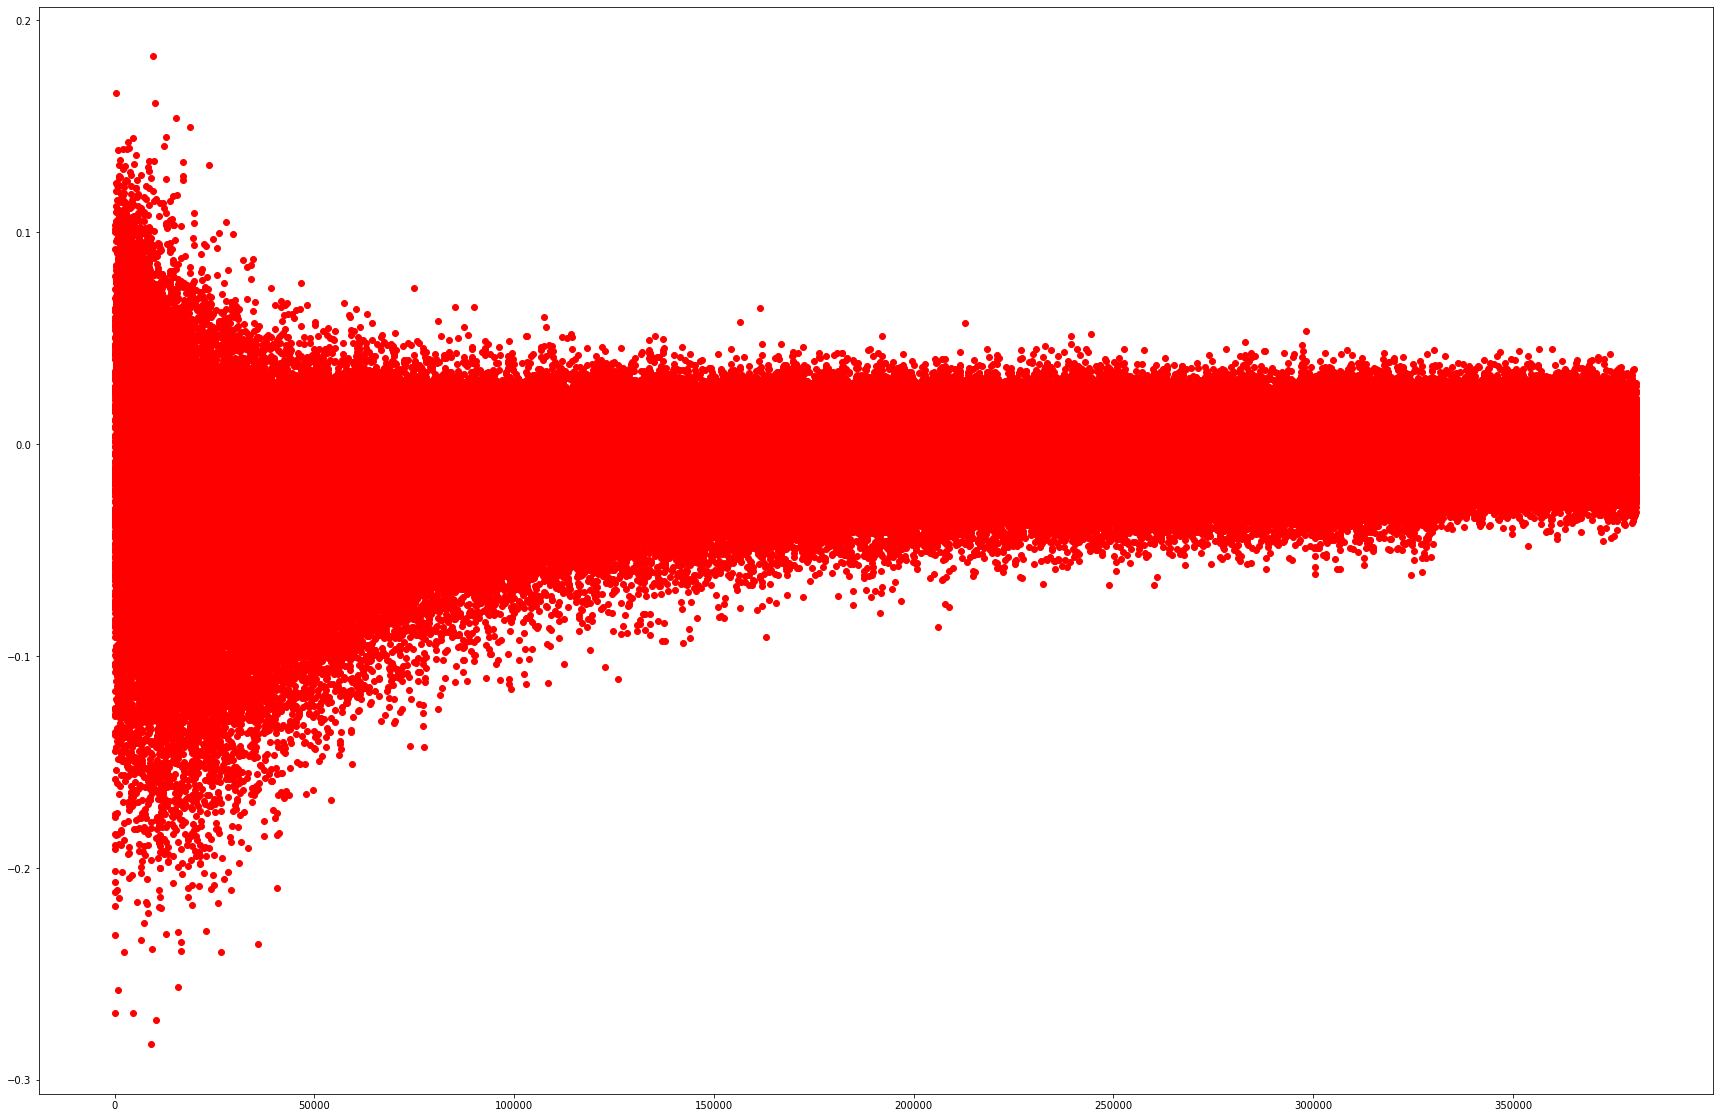

In [85]:
plt.figure(figsize=(30,20))
plt.scatter(*zip(*enumerate(inner_products)), color="red")
plt.show();

In [91]:
sorted_product_idx = np.argsort(inner_products)
print("Heaviest Weighted")
print("------------------------")
for x in sorted_product_idx[-50:]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Heaviest Weighted
------------------------
Word:  proved   --------  0.1196478
Word:  hanging   --------  0.12070952
Word:  computer   --------  0.12078053
Word:  except   --------  0.12078918
Word:  teeth   --------  0.121486165
Word:  decades   --------  0.121672176
Word:  fifty   --------  0.12169141
Word:  n   --------  0.12181641
Word:  professional   --------  0.12231143
Word:  light   --------  0.12253621
Word:  center   --------  0.12326041
Word:  touch   --------  0.123804376
Word:  twice   --------  0.1243407
Word:  ocean   --------  0.12449961
Word:  u   --------  0.12466199
Word:  parked   --------  0.124677256
Word:  recognized   --------  0.12502214
Word:  whenever   --------  0.12539473
Word:  mental   --------  0.12576461
Word:  star   --------  0.12612434
Word:  schedule   --------  0.12649836
Word:  slow   --------  0.1267867
Word:  anonymous   --------  0.12698552
Word:  foot   --------  0.12705
Word:  photo   --------  0.1285622
Word:  hundred   --------  0.1287479


In [92]:
sorted_product_idx = np.argsort(inner_products)
print("Least Weighted")
print("------------------------")
for x in sorted_product_idx[:50]:
    word = next((word for word, numero in final_word_ids.items() if numero == x), "unk")
    print("Word: ", word, "  -------- ", inner_products[x])

Least Weighted
------------------------
Word:  deadline   --------  -0.2832676
Word:  mattis   --------  -0.2715634
Word:  outrage   --------  -0.26861796
Word:  vox   --------  -0.2686054
Word:  accuses   --------  -0.2577374
Word:  backgrounds   --------  -0.25621068
Word:  seasonal   --------  -0.23968914
Word:  deportation   --------  -0.23964877
Word:  geared   --------  -0.23924457
Word:  proposition   --------  -0.23809427
Word:  belgian   --------  -0.23581058
Word:  propose   --------  -0.23512442
Word:  repeal   --------  -0.2339405
Word:  the   --------  -0.23158757
Word:  terrific   --------  -0.23097762
Word:  erased   --------  -0.23020507
Word:  fulfilling   --------  -0.22993004
Word:  meddling   --------  -0.22613649
Word:  accessing   --------  -0.22119582
Word:  retaliate   --------  -0.21909228
Word:  unauthorized   --------  -0.21856436
Word:  opt   --------  -0.21793023
Word:  respiratory   --------  -0.21734881
Word:  conventions   --------  -0.21719113
Word:  ex

In [ ]:
rollingcounts  = []
othercounts = []
for example in eval_data.examples:
    url = next(link for link, numero in final_url_ids.items() if numero == example['url'])
    if "rollingstone" in url:
        rollingcounts.append(len(list(set(example['text']))))
    else:
        othercounts.append(len(list(set(example['text']))))

In [98]:
rollingcounts = np.asarray(rollingcounts)
othercounts = np.asarray(othercounts)
print("Average Unique Words in Rollingstone Article: ", rollingcounts.mean())
print("Average Unique Words in remaining eval data Articles: ", othercounts.mean())

Average Unique Words in Rollingstone Article:  750.6373748609566
Average Unique Words in remaining eval data Articles:  324.94317663167504


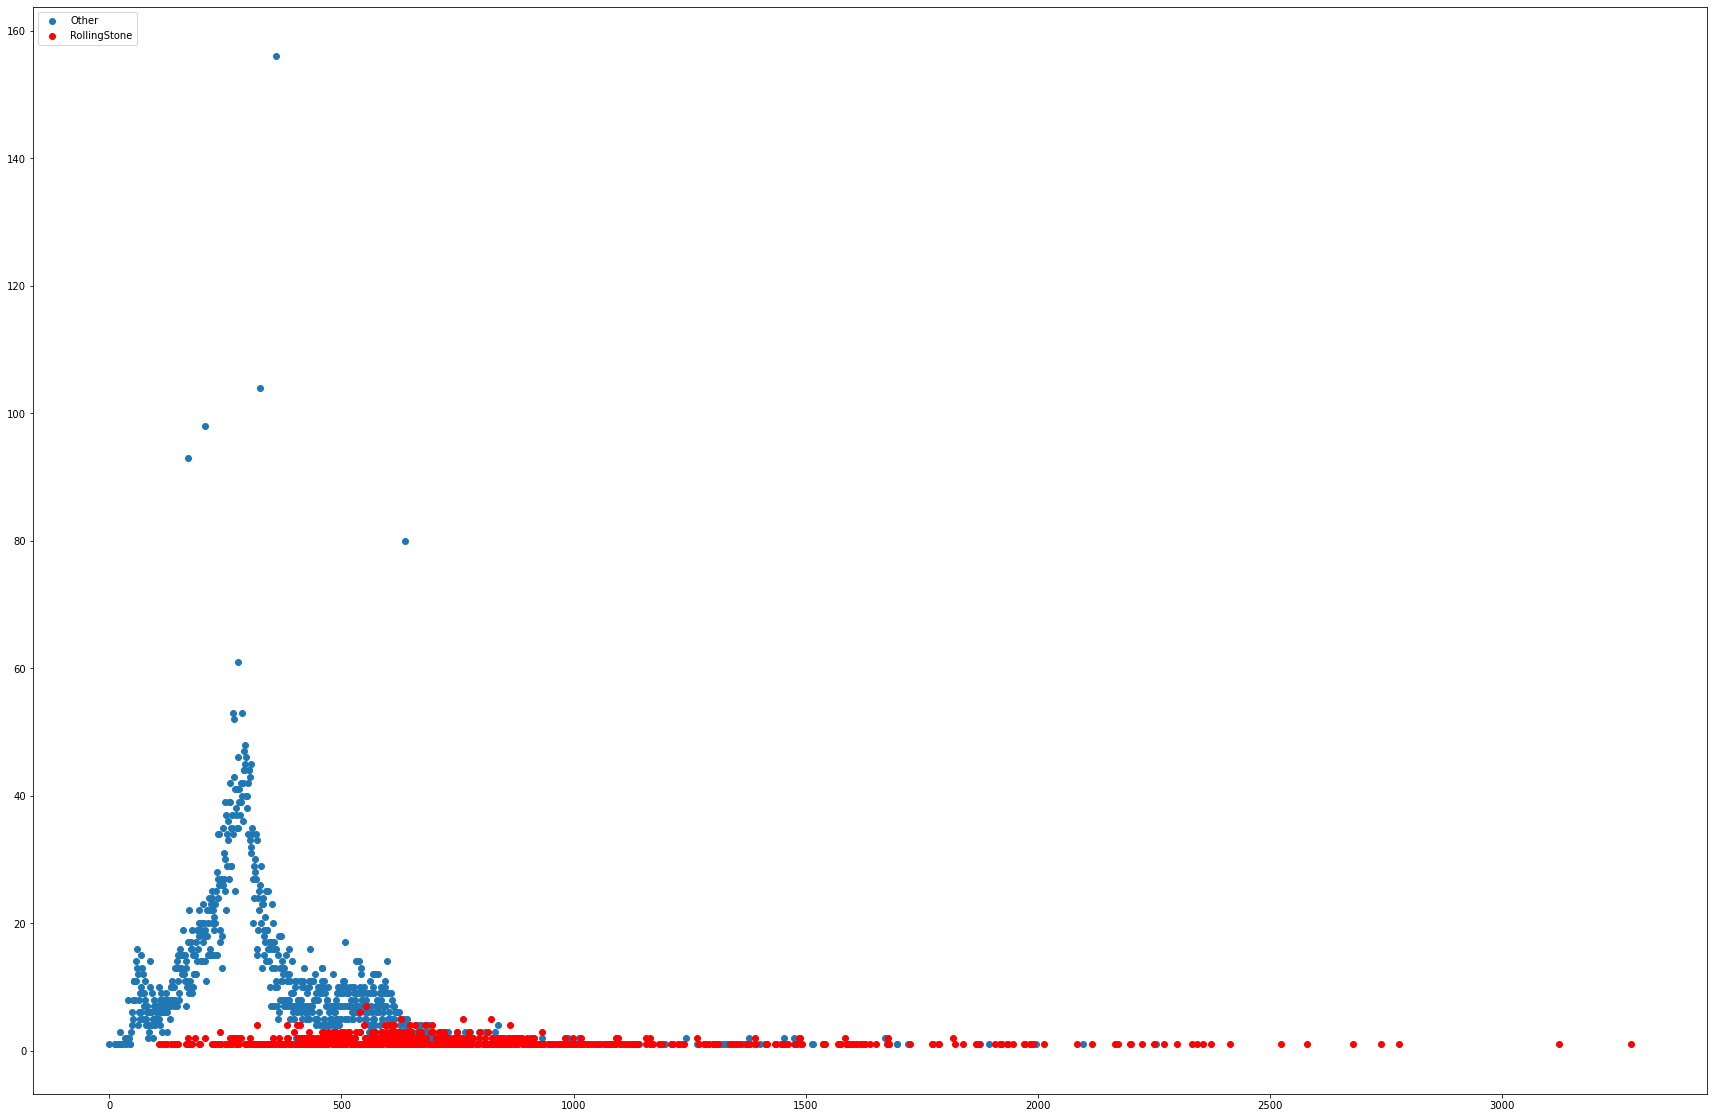

In [105]:
#Unique word counts for rollingstone articles compared to rest of eval_data
rolling_word_count_freq = collections.Counter()
rolling_word_count_freq.update(rollingcounts.tolist())
other_word_count_freq = collections.Counter()
other_word_count_freq.update(othercounts.tolist())

fig = plt.figure(figsize=(30,20))
ax1 = fig.add_subplot(111)
ax1.scatter(*zip(*other_word_count_freq.most_common()), label="Other")
ax1.scatter(*zip(*rolling_word_count_freq.most_common()), color="red", label="RollingStone")
plt.legend(loc='upper left');
plt.show();

In [97]:
for x,y in rollingcounter.most_common()[:100]:
    final=True
    for j,k in counter.most_common()[:100]:
        if x==j:
            final=False
            break
    if final:
        print(x)

213
549
924
1634
2143


In [102]:
next((word for word, numero in final_word_ids.items() if numero == 2143), "unk")

'life'

In [ ]:
long = 0
non_long = 0
links = list(final_url_ids.keys())
guardian_counter = collections.Counter()
vox_counter = collections.Counter()
for example in val_data.examples + train_data.examples:
    if example['longform'] == 1:
        long += 1
    else:
        non_long += 1
    url = links[example['url']]
    text=[]
    if "theguardian.com" in url:
        for x in example['title']:
            text.append(next((word for word, numero in final_word_ids.items() if numero == x), None))
        guardian_counter.update(text)
    elif "vox.com" in url:
        for x in example['title']:
            text.append(next((word for word, numero in final_word_ids.items() if numero == x), None))
        vox_counter.update(text)
print(guardian_counter.most_common(1000))
print(vox_counter.most_common(1000))